In [3]:
import pandas
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as D
from torch.autograd import Variable
import torch.optim as optim
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, TensorDataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [4]:
class Lin_Net(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim, act_function):
        super(Lin_Net, self).__init__()
        self.act_function = act_function
        
        self.lin1 = nn.Linear(input_dim, hidden_dim_1)
        self.lin2 = nn.Linear(hidden_dim, hidden_dim)
        self.lin3 = nn.Linear(hidden_dim, hidden_dim)
        self.lin4 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.act_function(self.lin1(x))
        x = self.act_function(self.lin2(x))
        x = self.act_function(self.lin3(x))
        x = self.lin4(x)
        return x

In [5]:
class MyDataset(D.Dataset):
    def __init__(self, x_tensor, y_tensor):
        self.x = torch.from_numpy(x_tensor)
        self.y = torch.from_numpy(y_tensor)
        
    def __getitem__(self, index):
        return (self.x[index], self.y[index])

    def __len__(self):
        return len(self.x)

In [6]:
def make_data(dataset, features, batch_size, debug=False):
    datasets = []
    for file in dataset:
        datasets.append(pd.read_csv("../" + file))
    dataset = pd.concat(datasets, axis=0, ignore_index=True)
    
    target = dataset["affect"]
    dataset_full = dataset[["word_count", "upper_word_count", "ent_word_count", "h_count", "s_count", "a_count", "f_count", "cons_punct_count"]]
    dataset_nolex = dataset[["word_count", "upper_word_count", "ent_word_count", "cons_punct_count"]]
    dataset_lex = dataset[["h_count", "s_count", "a_count", "f_count"]]
    
    # make train and test sets
    if features == "full": 
        train_x, test_x, train_y, test_y = train_test_split(dataset_full, target, test_size=0.2)
    elif features == "nolex":
        train_x, test_x, train_y, test_y = train_test_split(dataset_nolex, target, test_size=0.2)
    elif features == "lex": 
        train_x, test_x, train_y, test_y = train_test_split(dataset_lex, target, test_size=0.2)

    # make data loaders
    train_data = MyDataset(train_x.to_numpy(), train_y.to_numpy())
    test_data = MyDataset(test_x.to_numpy(), test_y.to_numpy())
    train_loader = DataLoader(dataset=train_data, batch_size=batch_size)
    test_loader = DataLoader(dataset=test_data, batch_size=1)
    
    if debug: 
        dataset_full = dataset_full.iloc[:10]
        target = target[:10]
        train_x, test_x, train_y, test_y = train_test_split(dataset_full, target, test_size=0.8)
        train_data = MyDataset(train_x.to_numpy(), train_y.to_numpy())
        train_loader = DataLoader(dataset=train_data, batch_size=batch_size)
        test_loader = DataLoader(dataset=train_data, batch_size=1)
    return train_loader, test_loader 

In [7]:
def log(summary, file):
    log = open(file, "a")
    log.write(summary)
    log.close()
    print(summary)

In [16]:
def train(train_loader, net, epochs, criterion, print_every, save_name, cuda, lr):
    open(save_name + "_train", "w").close()
    optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.5)
    error_curve = []
    net.train()
    for epoch in range(epochs):
        for index, (inputs, targets) in enumerate(train_loader):
            inputs, targets = inputs.float(), targets.long()
            if cuda: 
                inputs = inputs.cuda()
                targets = targets.cuda()
                net = net.cuda()
            pred = net(inputs)
            loss = criterion(pred.float(), targets)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            if ((index) % print_every == 0):
                log("batch: {}/{} in epoch {}/{} \n... loss: {}\n".
                    format((index+1), len(train_loader), (epoch+1), epochs, loss.item()), 
                    save_name + "_train")
        # save network after every epoch
        torch.save(net.state_dict(), save_name + ".pt")  
        # after every epoch save the error
        error_curve.append([epoch, loss.item()])
    log("\n" + str(error_curve), save_name + "_train")
    plot = plt.plot([item[0] for item in error_curve], [item[1] for item in error_curve])
    plt.savefig(save_name+"_train_error.png")

def test(test_loader, net, criterion, print_every, save_name, cuda):
    open(save_name + "_test", "w").close()
    confusion = []
    net.eval()
    loss_sum, correct, correct2 = 0, 0, 0
    for index, (inputs, targets) in enumerate(test_loader):
        inputs, targets = inputs.float(), targets.long()
        if cuda: 
            inputs = inputs.cuda()
            targets = targets.cuda()
            net = net.cuda()
        pred = net(inputs)
        pred_class = torch.max(pred.data, 1)[1]
        loss_sum += criterion(pred, targets).item()
        confusion.append([targets.item(), pred_class.item()])
        if pred_class.item() == targets.item(): 
            correct += 1
        if ((index) % print_every == 0):
            log("batch: {}/{}\n... correct: {}\n".
                format((index+1), len(test_loader), correct), 
                save_name + "_test")
           
    # give end report
    log("average test loss: {}, relative correct: {}\n\nconfusion:\n{}".
        format((loss_sum / len(test_loader)), (correct / len(test_loader)),str(confusion)), 
        save_name + "_test")

In [14]:
# create variables 
print("creating variables")
emotion_dataset = ["emotion_classification_1_clean.csv", "emotion_classification_2_clean.csv", "emotion_classification_3_clean.csv", "emotion_classification_4_clean.csv", "emotion_classification_5_clean.csv", "emotion_classification_6_clean.csv", "emotion_classification_7_clean.csv", "emotion_classification_8_clean.csv"]
tweet_dataset = ["crowdflower_clean.csv", "emoint_clean.csv", "tec_clean.csv"]
act_function = torch.sigmoid
criterion = nn.CrossEntropyLoss()
cuda = torch.cuda.is_available()
batch_size = 25

creating variables


batch: 1/1 in epoch 1/1000 
... loss: 1.410484790802002

batch: 1/1 in epoch 2/1000 
... loss: 1.03560209274292

batch: 1/1 in epoch 3/1000 
... loss: 0.8322607278823853

batch: 1/1 in epoch 4/1000 
... loss: 0.7617442607879639

batch: 1/1 in epoch 5/1000 
... loss: 0.7353168725967407

batch: 1/1 in epoch 6/1000 
... loss: 0.7236469984054565

batch: 1/1 in epoch 7/1000 
... loss: 0.7176548838615417

batch: 1/1 in epoch 8/1000 
... loss: 0.7140815258026123

batch: 1/1 in epoch 9/1000 
... loss: 0.7117377519607544

batch: 1/1 in epoch 10/1000 
... loss: 0.7100479602813721

batch: 1/1 in epoch 11/1000 
... loss: 0.7087364792823792

batch: 1/1 in epoch 12/1000 
... loss: 0.7076705694198608

batch: 1/1 in epoch 13/1000 
... loss: 0.7067698240280151

batch: 1/1 in epoch 14/1000 
... loss: 0.7059892416000366

batch: 1/1 in epoch 15/1000 
... loss: 0.7053015232086182

batch: 1/1 in epoch 16/1000 
... loss: 0.7046875953674316

batch: 1/1 in epoch 17/1000 
... loss: 0.7041341662406921

batch: 1/

batch: 1/1 in epoch 187/1000 
... loss: 0.6929201483726501

batch: 1/1 in epoch 188/1000 
... loss: 0.6929028034210205

batch: 1/1 in epoch 189/1000 
... loss: 0.6928853392601013

batch: 1/1 in epoch 190/1000 
... loss: 0.6928681135177612

batch: 1/1 in epoch 191/1000 
... loss: 0.6928508281707764

batch: 1/1 in epoch 192/1000 
... loss: 0.692833662033081

batch: 1/1 in epoch 193/1000 
... loss: 0.6928162574768066

batch: 1/1 in epoch 194/1000 
... loss: 0.6927989721298218

batch: 1/1 in epoch 195/1000 
... loss: 0.692781925201416

batch: 1/1 in epoch 196/1000 
... loss: 0.6927645206451416

batch: 1/1 in epoch 197/1000 
... loss: 0.6927474141120911

batch: 1/1 in epoch 198/1000 
... loss: 0.6927300691604614

batch: 1/1 in epoch 199/1000 
... loss: 0.6927129030227661

batch: 1/1 in epoch 200/1000 
... loss: 0.6926956176757812

batch: 1/1 in epoch 201/1000 
... loss: 0.6926782131195068

batch: 1/1 in epoch 202/1000 
... loss: 0.6926609873771667

batch: 1/1 in epoch 203/1000 
... loss: 0.

batch: 1/1 in epoch 362/1000 
... loss: 0.6890448927879333

batch: 1/1 in epoch 363/1000 
... loss: 0.6890111565589905

batch: 1/1 in epoch 364/1000 
... loss: 0.6889770030975342

batch: 1/1 in epoch 365/1000 
... loss: 0.6889427304267883

batch: 1/1 in epoch 366/1000 
... loss: 0.6889081597328186

batch: 1/1 in epoch 367/1000 
... loss: 0.6888733506202698

batch: 1/1 in epoch 368/1000 
... loss: 0.6888382434844971

batch: 1/1 in epoch 369/1000 
... loss: 0.6888031959533691

batch: 1/1 in epoch 370/1000 
... loss: 0.6887674331665039

batch: 1/1 in epoch 371/1000 
... loss: 0.6887317299842834

batch: 1/1 in epoch 372/1000 
... loss: 0.6886956691741943

batch: 1/1 in epoch 373/1000 
... loss: 0.6886594295501709

batch: 1/1 in epoch 374/1000 
... loss: 0.6886228322982788

batch: 1/1 in epoch 375/1000 
... loss: 0.6885861754417419

batch: 1/1 in epoch 376/1000 
... loss: 0.6885488629341125

batch: 1/1 in epoch 377/1000 
... loss: 0.6885115504264832

batch: 1/1 in epoch 378/1000 
... loss: 

batch: 1/1 in epoch 533/1000 
... loss: 0.6760441064834595

batch: 1/1 in epoch 534/1000 
... loss: 0.6758838295936584

batch: 1/1 in epoch 535/1000 
... loss: 0.6757216453552246

batch: 1/1 in epoch 536/1000 
... loss: 0.6755577325820923

batch: 1/1 in epoch 537/1000 
... loss: 0.675391435623169

batch: 1/1 in epoch 538/1000 
... loss: 0.6752234697341919

batch: 1/1 in epoch 539/1000 
... loss: 0.6750534772872925

batch: 1/1 in epoch 540/1000 
... loss: 0.674881637096405

batch: 1/1 in epoch 541/1000 
... loss: 0.6747076511383057

batch: 1/1 in epoch 542/1000 
... loss: 0.6745316386222839

batch: 1/1 in epoch 543/1000 
... loss: 0.6743534803390503

batch: 1/1 in epoch 544/1000 
... loss: 0.6741733551025391

batch: 1/1 in epoch 545/1000 
... loss: 0.6739909648895264

batch: 1/1 in epoch 546/1000 
... loss: 0.6738060712814331

batch: 1/1 in epoch 547/1000 
... loss: 0.6736193895339966

batch: 1/1 in epoch 548/1000 
... loss: 0.6734300255775452

batch: 1/1 in epoch 549/1000 
... loss: 0.

batch: 1/1 in epoch 672/1000 
... loss: 0.6094576120376587

batch: 1/1 in epoch 673/1000 
... loss: 0.6082589626312256

batch: 1/1 in epoch 674/1000 
... loss: 0.6070394515991211

batch: 1/1 in epoch 675/1000 
... loss: 0.6057977676391602

batch: 1/1 in epoch 676/1000 
... loss: 0.6045346260070801

batch: 1/1 in epoch 677/1000 
... loss: 0.603249192237854

batch: 1/1 in epoch 678/1000 
... loss: 0.6019406318664551

batch: 1/1 in epoch 679/1000 
... loss: 0.6006091237068176

batch: 1/1 in epoch 680/1000 
... loss: 0.5992540121078491

batch: 1/1 in epoch 681/1000 
... loss: 0.5978747606277466

batch: 1/1 in epoch 682/1000 
... loss: 0.5964714288711548

batch: 1/1 in epoch 683/1000 
... loss: 0.5950427651405334

batch: 1/1 in epoch 684/1000 
... loss: 0.5935887098312378

batch: 1/1 in epoch 685/1000 
... loss: 0.5921087265014648

batch: 1/1 in epoch 686/1000 
... loss: 0.5906026363372803

batch: 1/1 in epoch 687/1000 
... loss: 0.5890696048736572

batch: 1/1 in epoch 688/1000 
... loss: 0

batch: 1/1 in epoch 841/1000 
... loss: 0.10085035860538483

batch: 1/1 in epoch 842/1000 
... loss: 0.09915752708911896

batch: 1/1 in epoch 843/1000 
... loss: 0.0975007638335228

batch: 1/1 in epoch 844/1000 
... loss: 0.09587915241718292

batch: 1/1 in epoch 845/1000 
... loss: 0.09429207444190979

batch: 1/1 in epoch 846/1000 
... loss: 0.0927388072013855

batch: 1/1 in epoch 847/1000 
... loss: 0.09121870994567871

batch: 1/1 in epoch 848/1000 
... loss: 0.0897311121225357

batch: 1/1 in epoch 849/1000 
... loss: 0.08827508240938187

batch: 1/1 in epoch 850/1000 
... loss: 0.0868503749370575

batch: 1/1 in epoch 851/1000 
... loss: 0.08545581251382828

batch: 1/1 in epoch 852/1000 
... loss: 0.08409103006124496

batch: 1/1 in epoch 853/1000 
... loss: 0.08275526762008667

batch: 1/1 in epoch 854/1000 
... loss: 0.08144789934158325

batch: 1/1 in epoch 855/1000 
... loss: 0.08016834408044815

batch: 1/1 in epoch 856/1000 
... loss: 0.07891585677862167

batch: 1/1 in epoch 857/1000

batch: 1/2
... correct: 1

average test loss: 0.017284181900322437, relative correct: 1.0

confusion:
[[1, 1], [0, 0]]
... done


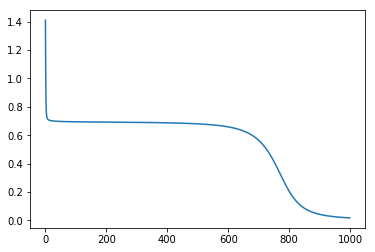

In [18]:
# debug set
net_full = Lin_Net(8, 4, 64, 64, act_function)
train_loader_debug, test_loader_debug = make_data(emotion_dataset, "full", batch_size, True)
train(train_loader_debug, net_full, 1000, criterion, 100, "../logs/cross_debug", cuda, 0.1)
test(test_loader_debug, net_full, criterion, 100, "../logs/cross_debug", cuda)

print("... done")



In [ ]:
print("-------- net_lin_emotion_full")
net_full = Lin_Net(8, 4, 64, act_function)
train_loader_emotion_full, test_loader_emotion_full = make_data(emotion_dataset, "full", batch_size)
train(train_loader_emotion_full, net_full, 100, criterion, 5000, "../logs/cross_"+net_name, cuda, 0.1)
test(test_loader_emotion_full, net_full, criterion, 1000, "../logs/cross_emotion_full")

print("-------- net_lin_emotion_nolex")
net_half = Lin_Net(4, 4, 64, act_function)
train_loader_emotion_nolex, test_loader_emotion_nolex = make_data(emotion_dataset, "nolex", batch_size)
train(train_loader_emotion_nolex, net_half, 100, criterion, 5000, "../logs/cross_"+net_name, cuda, 0.1)
test(test_loader_emotion_nolex, net_half, criterion, 1000, "../logs/cross_emotion_nolex")

print("-------- net_lin_emotion_lex")
net_half = Lin_Net(4, 4, 64, act_function)
train_loader_emotion_lex, test_loader_emotion_lex = make_data(emotion_dataset, "lex", batch_size)
train(train_loader_emotion_lex, net_half, 100, criterion, 5000, "../logs/cross_"+net_name, cuda, 0.1)
test(test_loader_emotion_lex, net_half, criterion, 1000, "../logs/cross_emotion_lex")

print("-------- net_lin_tweet_full")
net_full = Lin_Net(8, 4, 64, act_function)
train_loader_tweet_full, test_loader_tweet_full = make_data(tweet_dataset, "full", batch_size)
train(train_loader_tweet_full, net_full, 100, criterion, 5000, "../logs/cross_"+net_name, cuda, 0.1)
test(test_loader_tweet_full, net_full, criterion, 1000, "../logs/cross_tweet_full")

print("-------- net_lin_tweet_nolex")
net_half = Lin_Net(4, 4, 64, act_function)
train_loader_tweet_nolex, test_loader_tweet_nolex = make_data(tweet_dataset, "nolex", batch_size)
train(train_loader_tweet_nolex, net_half, 100, criterion, 5000, "../logs/cross_"+net_name, cuda, 0.1)
test(test_loader_tweet_nolex, net_half, criterion, 1000, "../logs/net_lin_tweet_nolex")

print("-------- net_lin_tweet_lex")
net_half = Lin_Net(4, 4, 64, act_function)
train_loader_tweet_lex, test_loader_tweet_lex = make_data(tweet_dataset, "lex", batch_size)
train(train_loader_tweet_lex, net_half, 100, criterion, 5000, "../logs/cross_"+net_name, cuda, 0.1)
test(test_loader_tweet_lex, net_half, criterion, 1000, "../logs/net_lin_tweet_lex")

print("...done")